In [1]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
from shutil import copy, rmtree
import matplotlib
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys, logging
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D

if "__file__" not in dir():

    root='/data'

    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommunNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommunNoteBookesPath)   
    %run Animal_Tags.ipynb
    %run UtilityTools.ipynb
    %run BatchRatBehavior.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run Animal_Tags.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run Lesion_Size.ipynb

    os.chdir(CWD)

    defaultParam={
        "binSize":0.25,
        "trialOffset":20., #max end of trial, in seconds (position will be cutted)
        "sigmaSmoothPosition":0.1,  #smooth the position
        #"sigmaSmoothPosition":0.33 for pavel dataType
        "sigmaSmoothSpeed":0.3, #smooth the speed
        "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                      #min to correct start, max to correct jumps
        "pawFrequencyRange":[2.,10.],
        "startAnalysisParams":[10,0.2,0.5],
        "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
        "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked

        #parameter to detect end of trial (first position minima)
        "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
        "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
        "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
        }
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 15}
    print('Done!')

Done!


In [2]:
class HistologyExcel(ReadExcelFile):

    def __init__(self,*args,**kwargs):
#         assert "fileName" in kwargs, "Specify the path to the histology excel"
#         assert kwargs['fileName'].endswith(("_hist.xlsx","_hist.xls")), "Invalid histology excel path"
        super().__init__(*args,**kwargs)
#         self.check_structure()
        self.df=self.excelData['lesionData']
        self.feed=self.excelData['settings'].axes[1][1]
        
        self.dic={
                  '1ROI_lesion':         {'A':0,'X':12,'Y':24},
                  '1ROI_total':          {'A':1,'X':13,'Y':25},
                  '1Off-ROI_lesion':     {'A':2,'X':14,'Y':26},
                  '1Ventricule':         {'A':3,'X':15,'Y':27},
                  '1Hemisphere':         {'A':4,'X':16,'Y':28},
                  '2ROI_lesion':         {'A':5,'X':17,'Y':29},
                  '2ROI_total':          {'A':6,'X':18,'Y':30},
                  '2Off-ROI_lesion':     {'A':7,'X':19,'Y':31},
                  '2Ventricule':         {'A':8,'X':20,'Y':32},
                  '2Hemisphere':         {'A':9,'X':21,'Y':33}
                 }
        #With reference to the Bregma, range of striatum within which DLS and DMS will be defined
        self.bigStriatum=(-0.3, 1.8)
        
        #With reference to the Bregma, thresholds by which rostral and caudal striatum are defined
        self.rostral= 2.1
        self.caudal = -1
    
    def check_structure(self):
        assert self.excelData['lesionData'].iloc[4][0]=='1Hemisphere'
        assert self.excelData['lesionData'].iloc[11][0]=='X'
        assert self.excelData['lesionData'].iloc[23][0]=='Y'
        assert self.excelData['settings'].axes[1][0]=='feed', 'feed was not found'
        
    def measure_vol(self,key):
        """
        This function generalizes the lesion_vol methods
        to measure the volume of any key input
        This function calculates the volume by assuming area  to be circular, 
        using a series of truncated cone volumes.
        """
        idx=self.dic[key]['A']
        vol=[]
        for i,(sec1,sec2) in enumerate(zip(self.df.axes[1][1:-1],self.df.axes[1][2:])):
            if not isinstance(sec2,(int,float)):
                #in case extra columns are being detected
                continue
            h=abs(sec2-sec1)
            r1=np.sqrt(self.df.iloc[idx][i+1]/np.pi)
            r2=np.sqrt(self.df.iloc[idx][i+2]/np.pi)
            vol.append(h*(r1**2+r1*r2+r2**2))
                
        return vol
        
    def lesioned_vol(self):
        volLesion=self.measure_vol('1ROI_lesion')
        volLesion.extend(self.measure_vol('2ROI_lesion'))
        volTotal=self.measure_vol('1ROI_total')
        volTotal.extend(self.measure_vol('2ROI_total'))

        return volLesion,volTotal
    
    def lesion_size(self):
        volLesion,volTotal=self.lesioned_vol()
        return np.nansum(volLesion)/np.nansum(volTotal)
    
    def lesion_size_symmetry(self):
        """
        one is perfect, any deviation from one means assymetric
        """
        volLesion1=self.measure_vol('1ROI_lesion')
        volLesion2=self.measure_vol('2ROI_lesion')

        return np.nansum(volLesion1)/np.nansum(volLesion2)
        
    
    def off_lesioned_vol(self):
        """
        this method returns the total off-target lesioned volume
        """
        volLesion=self.measure_vol('1Off-ROI_lesion')
        volLesion.extend(self.measure_vol('2Off-ROI_lesion'))
        return np.nansum(volLesion)

    def lesion_normal_centeroid(self,key='X'):
        assert key in ('X','Y'), "Wrong key"
        
        lesion1= self.dic['1ROI_lesion'][key] #left
        lesion2= self.dic['2ROI_lesion'][key] #right
        str1   = self.dic['1ROI_total'] [key]
        str2   = self.dic['2ROI_total'] [key]
        hemi1  = self.dic['1Hemisphere'][key]
        hemi2  = self.dic['2Hemisphere'][key]
        
        cent_left= []
        cent_right=[]
        anterioposterior=[]
        for col in range(1,len(self.df.axes[1])):
            if not isinstance(self.df.axes[1][col],(int,float)):
                #in case extra columns are being detected
                continue
            midline=np.mean([self.df.iloc[hemi1][col],self.df.iloc[hemi2][col]])
            anterioposterior.append(self.df.axes[1][col])
            
            cent_left.append (-(self.df.iloc[lesion1][col]-self.df.iloc[str1][col])  \
                              /midline)
            
            cent_right.append(+(self.df.iloc[lesion2][col]-self.df.iloc[str2][col])  \
                              /midline)
                
        return cent_left,cent_right,anterioposterior
    
    def lesion_location(self,key='X'):
        cent_left,cent_right,anterioposterior= self.lesion_normal_centeroid(key=key)
        
        cents=[center for i,center in enumerate(cent_left)
               if anterioposterior[i]>=self.bigStriatum[0] and anterioposterior[i]<=self.bigStriatum[1]]
        cents.extend([center for i,center in enumerate(cent_right) 
                      if anterioposterior[i]>=self.bigStriatum[0] and anterioposterior[i]<=self.bigStriatum[1]])
        return np.nanmean(cents)
    
    def lesion_tails(self):
        """
        this method returns lesion ratio rostral|caudal to self.rostral|self.caudal
        """
        lesion1= self.dic['1ROI_lesion']['A']
        lesion2= self.dic['2ROI_lesion']['A']
        striatum1= self.dic['1ROI_total']['A']
        striatum2= self.dic['2ROI_total']['A']

        def lesion_ratio(slide):
            hemi1=self.df.iloc[lesion1][slide]/self.df.iloc[striatum1][slide]
            hemi2=self.df.iloc[lesion2][slide]/self.df.iloc[striatum2][slide]
            return (hemi1+hemi2)/2
        
        rostral=[]
        caudal=[]
        for col in range(1,len(self.df.axes[1])):
            if not isinstance(self.df.axes[1][col],(int,float)):
                #in case extra columns are being detected
                continue
            if   self.df.axes[1][col] > self.rostral:
                rostral.append(lesion_ratio(col))
            elif self.df.axes[1][col] < self.caudal:
                caudal.append(lesion_ratio(col))
        
        out={'rostral':np.mean(rostral), 'caudal' :np.mean(caudal)}
        
        return out                     
        
    @classmethod
    def read_all(cls,root):
        excelPaths=os.path.join(root,'Rat*','Rat???_hist.xls*')
        files=glob.glob(excelPaths)

        lesionData=[]
        failed=[]
        for file in files:
            animal='Rat'+file.split(os.sep+'Rat')[1]
            try:
                lesionData.append(cls(root,animal,file))
            except:
                failed.append(animal)
        logging.warning("failed at: "+str(failed))
        return lesionData

In [ ]:
if "__file__" not in dir():
    a=HistologyExcel('/NAS02','Rat240')
    print(a.lesion_location(),a.lesion_size(),a.lesion_tails())

### Lesion size vs. behavior for Early lesion animals

In [3]:
def early_lesion_size_control(root,PerfParamToPlot,AnimalProfile, animalList, Ndays=-5):
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    """
#     allFiles=HistologyExcel.read_all('/NAS02')

    size=[]
    loc=[]
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistologyExcel('/NAS02',animal)
        except AssertionError as e:
            logging.warning(repr(e))
            continue
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        res=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=AnimalProfile,
                                stop_date='',redoPreprocess=False,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][Ndays:]

        try:
            t1=np.nanmedian(res)
            t2=i.lesion_location()
            t3=i.lesion_size()
        except Exception as e:
            logging.warning(repr(e))
            continue
        behav.append(t1)
        loc.append(t2)
        size.append(t3)
        animals.append(animal)
    
    return behav, loc, size, animals    

2 behavioral params correlated, lesion size as marker size

In [ ]:
if "__file__" not in dir():
    
    #Define desired profile dictionary
    AnimalProfile={'Type':'Good',
         'option': ['not used'],
         'rewardType':'Progressive',
         'initialSpeed':['10'],
         'Speed':'10',
         'Tag':['Early-Lesion_DS','Early-Lesion_DMS','Early-Lesion_DLS']
                  }
    
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed","Tortuosity","Run Distance"
                      ,"Delivered Reward Ratio","mean entrance time (sec)"]

    PerfParamToPlot1 =['standard deviation of entrance time']#["Forward Running Speed"]
    
    #Assymetric lesioned animals
    BadAnimals=['Rat081', 'Rat115', 'Rat136', 'Rat203', 'Rat239', 'Rat240', 'Rat266', 'Rat269']
    
    animalList=batch_get_animal_list(root,AnimalProfile)
    
    animalList=[animal for animal in animalList if animal not in BadAnimals]
    print("animals that will be analyzed: %s"%animalList)
    
    behav1, loc1, size1, animals1= early_lesion_size_control(root,PerfParamToPlot1,AnimalProfile, animalList)
    
    PerfParamToPlot2 =['Forward Running Speed']#["Forward Running Speed"]
    behav2, loc2, size2, animals2= early_lesion_size_control(root,PerfParamToPlot2,AnimalProfile, animalList)
    
    #PLOTTING
    color={'Early-Lesion_DS':'r','Early-Lesion_DMS':'g', 'Early-Lesion_DLS':'b'}

    ax=plt.subplot(111)
    for i,animal in enumerate(animals1):
        tag=batch_get_session_list(root,animalList=[animal],profile=AnimalProfile)['Tag'][5]
        ax.scatter(behav1[i], behav2[i], c=color[tag], s=size1[i]*50, label=tag);

        
        
    handles = ax.get_legend_handles_labels()
    handles = [handles[0][-2], handles[0][-1], handles[0][-3],handles[0][-4]]
    ax.legend(handles, color.keys());
    leg = ax.get_legend()
    for i,c in enumerate(color.values()):
        leg.legendHandles[i].set_color(c)
        leg.legendHandles[i]._sizes=[26]

    ax.set_ylabel(PerfParamToPlot2[0]);
    ax.set_xlabel(PerfParamToPlot1[0]);
    ax.set_xlim([.5,6])
    ax.set_ylim([10,60])
    # plt.annotate(animal[-3:], (behav[i], size[i]))


one param vs lesion size correlate, with a few control animals included

In [ ]:
if "__file__" not in dir():
    
    #Define desired profile dictionary
    AnimalProfile={'Type':'Good',
         'option': ['not used'],
         'rewardType':'Progressive',
         'initialSpeed':['10'],
         'Speed':'10',
         'Tag':['Early-Lesion_DS','Early-Lesion_DMS','Early-Lesion_DLS']
                  }
    
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed","Tortuosity","Run Distance"
                      ,"Delivered Reward Ratio","mean entrance time (sec)"]

    PerfParamToPlot =['Forward Running Speed']#["Forward Running Speed"]
    
    #Assymetric lesioned animals
    BadAnimals=[]
    
    animalList=batch_get_animal_list(root,AnimalProfile)
    
    animalList=[animal for animal in animalList if animal not in BadAnimals]
    print("animals that will be analyzed: %s"%animalList)
    
    behav, loc, size, animals= early_lesion_size_control(root,PerfParamToPlot,AnimalProfile, animalList)
    
    
    #THE CONTROL GROUP
    AnimalProfile2={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['10','0'],
         'Speed':'10',
         'Tag':'Control'
                  }

    animalList2=batch_get_animal_list(root,AnimalProfile2)
    controlBehav=[]
    for animal in animalList2:
        a=plot_learningCurves(root,animal,PerfParamToPlot=PerfParamToPlot,profile=AnimalProfile2,
                        stop_date='',redoPreprocess=False,
                        redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][-5:]
        controlBehav.append(np.nanmedian(a))
    
    #PLOTTING
    color={'Early-Lesion_DS':'r','Early-Lesion_DMS':'g', 'Early-Lesion_DLS':'b', 'Control':'k'}

    ax=plt.subplot(111)
    for i,animal in enumerate(animals):
        tag=batch_get_session_list(root,animalList=[animal],profile=AnimalProfile)['Tag'][5]
        ax.scatter(size[i], behav[i], c=color[tag], label=tag);
        plt.annotate(animal[-3:], ( size[i],behav[i]))
        
    tag='Control'
#     for i,animal in enumerate(animalList2):
#         ax.scatter(0, controlBehav[i], c=color[tag], label=tag)
    ax.boxplot(controlBehav,whis=0,positions=[0],widths=.05,manage_xticks=False,sym='')
    
    handles = ax.get_legend_handles_labels()
    handles = [handles[0][-2], handles[0][-1], handles[0][-3],handles[0][-4]]
    ax.legend(handles, color.keys());
    leg = ax.get_legend()
    for i,c in enumerate(color.values()):
        leg.legendHandles[i].set_color(c)

    ax.set_ylabel(PerfParamToPlot[0]);
    ax.set_xlabel('Lesion Size');

just one behav param vs size

In [ ]:
if "__file__" not in dir():
    
    #Define desired profile dictionary
    AnimalProfile={'Type':'Good',
         'option': ['not used'],
         'rewardType':'Progressive',
         'initialSpeed':['10'],
         'Speed':'10',
         'Tag':['Early-Lesion_DS','Early-Lesion_DMS','Early-Lesion_DLS']
                  }
    
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed","Tortuosity","Run Distance"
                      ,"Delivered Reward Ratio","mean entrance time (sec)"]

    PerfParamToPlot =["Forward Running Speed"]#["Entrance Time MSE"]#["Forward Speed"]
    
    #Assymetric lesioned animals
    BadAnimals=[]
    
    animalList=batch_get_animal_list(root,AnimalProfile)
    
    animalList=[animal for animal in animalList if animal not in BadAnimals]
    print("animals that will be analyzed: %s"%animalList)
    
    behav, loc, size, animals= early_lesion_size_control(root,PerfParamToPlot,AnimalProfile, animalList)


In [ ]:
if "__file__" not in dir():
    plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    sc=ax.scatter(loc,size)
    ax.set_ylabel('Size')
    ax.set_xlabel('DMS          lesion centroid          DLS')
    ax.set_title('Lesion Size v. location');
    ax.axvline(0,color='k');
    ax.set_xlim([-.15,.15])

    for i, txt in enumerate(animals):
        ax.annotate(txt[-3:], (loc[i], size[i]))

In [ ]:
if "__file__" not in dir():
    cm = plt.cm.get_cmap('viridis')
    ax=plt.subplot(111)
    sc=ax.scatter(loc,behav,c=size,cmap=cm)
    ax.set_ylabel(PerfParamToPlot[0])
    ax.set_xlabel('DMS          lesion centroid          DLS')
    ax.set_title('r='+str(np.corrcoef(behav,loc)[0,1])[:5]+', p='+str(scipy.stats.pearsonr(behav,loc)[1])[:5]);
    ax.axvline(0,color='k');
    ax.set_xlim([-.15,.15])
    cbAx=plt.colorbar(sc,ax=ax);
    cbAx.set_label("Lesion Size")

    for i, txt in enumerate(animals):
        ax.annotate(txt[-3:], (loc[i], behav[i]))

### Lesion size vs. behavior for LATE lesion animals

In [4]:
def late_lesion_size_control(root,PerfParamToPlot,profile1,profile2,param={},Ndays=5):
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    use for late lesion animals
    """
    animalList=event_detect(root,profile1,profile2)[1].keys()
#     allFiles=HistologyExcel.read_all('/NAS02')
    
    size=[]
    loc=[]
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistologyExcel('/NAS02',animal)
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        res1=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile1,
                                stop_date='',redoPreprocess=False,parameter=param,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][-Ndays:]
        
        res2=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile2,
                                stop_date='',redoPreprocess=False,parameter=param,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][:Ndays]


        try:
            t1=np.nanmedian(res2)/np.nanmedian(res1)
            t2=i.lesion_location()
            t3=i.lesion_size()
        except Exception as e:
            logging.warning(repr(e))
            continue
        behav.append(t1)
        loc.append(t2)
        size.append(t3)
        animals.append(animal)
    
    return behav, loc, size, animals

def late_lesion_size_correlation(root,PerfParamToPlot,profile1,param={},Ndays=5):
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    use for late lesion animals
    """
    animalList=batch_get_animal_list(root,profile1)
    
    size=[]
    loc=[]
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistologyExcel('/NAS02',animal)
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        res1=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile1,
                                stop_date='',redoPreprocess=False,parameter=param,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][:Ndays]

        try:
            t1=np.nanmedian(res1)
            t2=i.lesion_location()
            t3=i.lesion_size()
        except Exception as e:
            logging.warning(repr(e))
            continue
        behav.append(t1)
        loc.append(t2)
        size.append(t3)
        animals.append(animal)
    
    return behav, loc, size, animals    

In [ ]:
if "__file__" not in dir():
    profile1={'Type':'Good',
#              'option': ['not used'],
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control','Control-AfterBreak','Control-Late-NoTimeout-BackToTimeout',
                    'Control-NoTimeout-Control']
             }
    profile2={'Type':'Good',
#              'option': ['not used'],
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS']
             }
    
    _,sessionDic=event_detect(root,profile1,profile2)
    
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",
                      'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed",
                      "Tortuosity","Run Distance","Delivered Reward Ratio","mean entrance time (sec)"]

    PerfParamToPlot=["Forward Running Speed"]#['Forward Speed']
    
    profile={'Type':'Good'}#AnimalProfile
    # this is where you define a list of functions you want to run on your data (usually, don't touch!)
    plotFunctionList=[]

    
    Behav, Loc, Size, Animals=late_lesion_size_control(root,PerfParamToPlot,profile1,profile2,Ndays=5)

In [ ]:
if "__file__" not in dir():
    plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    sc=ax.scatter(Loc,Size)
    ax.set_ylabel('Size')
    ax.set_xlabel('DMS          lesion centroid          DLS')
    ax.set_title('Lesion Size v. location');
    ax.axvline(0,color='k');
    ax.set_xlim([-.15,.15])

    for i, txt in enumerate(Animals):
        ax.annotate(txt[-3:], (Loc[i], Size[i]))

In [ ]:
if "__file__" not in dir():
    cm = plt.cm.get_cmap('viridis')
    ax=plt.subplot(111)
    sc=ax.scatter(Loc,Behav,c=Size,cmap=cm)
    ax.set_ylabel(PerfParamToPlot[0])
    ax.set_xlabel('DMS          lesion centroid          DLS')
    ax.set_title('r='+str(np.corrcoef(Behav,Loc)[0,1])[:5]+', p='+str(scipy.stats.pearsonr(Behav,Loc)[1])[:5]);
    ax.axvline(0,color='k');
    ax.axhline(1,color='k');
    ax.set_xlim([-.15,.15]);
#     ax.set_ylim([0.25,1.5]);
    cbAx=plt.colorbar(sc,ax=ax);
    cbAx.set_label("Lesion Size");

    for i, txt in enumerate(Animals):
        ax.annotate(txt[-3:], (Loc[i], Behav[i]))

In [ ]:
if "__file__" not in dir():
    color={'Late-Lesion_DS':'r','Late-Lesion_DMS':'g', 'Late-Lesion_DLS':'b', 'Control':'k'}

    ax=plt.subplot(111)
    for i,animal in enumerate(Animals):
        tag=batch_get_session_list(root,animalList=[animal],profile=profile2)['Tag'][5]
        ax.scatter(Size[i], Behav[i], c=color[tag], label=tag);
        plt.annotate(animal[-3:], (Size[i],Behav[i]))
    ax.set_ylabel(PerfParamToPlot[0]);
    ax.set_xlabel('Lesion Size');
    handles = ax.get_legend_handles_labels()
    handles = [handles[0][-2], handles[0][-1], handles[0][-3],handles[0][-4]]
    ax.legend(handles, color.keys());
    leg = ax.get_legend()
    for i,c in enumerate(color.values()):
        leg.legendHandles[i].set_color(c)

one param vs lesion size correlate, with a few control animals included

In [ ]:
if "__file__" not in dir():
    
    #Define desired profile dictionary
    AnimalProfile={'Type':'Good',
                   'option': ['not used'],
                   'rewardType':'Progressive',
                   'initialSpeed':['0','10'],
                   'Speed':'10',
                   'Tag':['Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS']
             }

    
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed","Tortuosity","Run Distance"
                      ,"Delivered Reward Ratio","mean entrance time (sec)"]

    PerfParamToPlot =["Forward Running Speed"]#["Forward Running Speed"]
    
    #Assymetric lesioned animals
    
    animalList=batch_get_animal_list(root,AnimalProfile)
    
   
    Behav, Loc, Size, Animals=late_lesion_size_correlation(root,PerfParamToPlot,AnimalProfile)   
    
    #THE CONTROL GROUP
    AnimalProfile2={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['10','0'],
         'Speed':'10',
         'Tag':'Control'
                  }

    animalList2=batch_get_animal_list(root,AnimalProfile2)
    controlBehav=[]
    for animal in animalList2:
        a=plot_learningCurves(root,animal,PerfParamToPlot=PerfParamToPlot,profile=AnimalProfile2,
                        stop_date='',redoPreprocess=False,
                        redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][-5:]
        controlBehav.append(np.nanmedian(a))
    
    #PLOTTING
    color={'Late-Lesion_DS':'r','Late-Lesion_DMS':'g', 'Late-Lesion_DLS':'b', 'Control':'k'}

    ax=plt.subplot(111)
    for i,animal in enumerate(Animals):
        tag=batch_get_session_list(root,animalList=[animal],profile=AnimalProfile)['Tag'][5]
        ax.scatter(Size[i], Behav[i], c=color[tag], label=tag);
        plt.annotate(animal[-3:], (Size[i],Behav[i]))
    tag=AnimalProfile2['Tag']
#     for i,animal in enumerate(animalList2):
#         ax.scatter(0, controlBehav[i], c=color[tag], label=tag)
# #         plt.annotate(animal[-3:], (0,controlBehav[i]))
    ax.boxplot(controlBehav,whis=0,positions=[0],widths=.05,manage_xticks=False,sym='')

    handles = ax.get_legend_handles_labels()
    handles = [handles[0][-2], handles[0][-1], handles[0][-3],handles[0][-4]]
    ax.legend(handles, color.keys());
    leg = ax.get_legend()
    for i,c in enumerate(color.values()):
        leg.legendHandles[i].set_color(c)

    ax.set_ylabel(PerfParamToPlot[0]);
    ax.set_xlabel('Lesion Size');
    # plt.annotate(animal[-3:], (behav[i], size[i]))


### GENERAL: Lesion size vs. behavior for LATE lesion animals

In [5]:
def late_lesion_data(root,PerfParamToPlot,profile1,profile2,
                     method=['lesion_size','lesion_location'],param={},Ndays=5):
    
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    use for late lesion animals
    """
    class HistoExcelData(HistologyExcel):        
        def hemi_lesion_size(self):
            volLesion=self.measure_vol('1ROI_lesion')
            volTotal =self.measure_vol('1ROI_total' )
            size1=np.nansum(volLesion)/np.nansum(volTotal)
            
            volLesion=self.measure_vol('2ROI_lesion')
            volTotal =self.measure_vol('2ROI_total' )
            size2=np.nansum(volLesion)/np.nansum(volTotal)
            
            return size1, size2
        
        def hemi_lesion_location(self):
            cent_left, cent_right,_= self.lesion_normal_centeroid(key='X')
            return np.nanmedian(cent_left), np.nanmedian(cent_right)
        
        def lesion_size1(self):
            return self.hemi_lesion_size()[0]
        
        def lesion_size2(self):
            return self.hemi_lesion_size()[1]
        
        def lesion_location1(self):
            return self.hemi_lesion_location()[0]
        
        def lesion_location2(self):
            return self.hemi_lesion_location()[1]
        
        def lesion_depth_loc(self):
            d_left,d_right,_=self.lesion_normal_centeroid(key='Y')
            return np.nanmedian(d_left), np.nanmedian(d_right)
        
        def lesion_depth1(self):
            return self.lesion_depth_loc()[0]
    
        def lesion_depth2(self):
            return self.lesion_depth_loc()[1]
    
    animalList=event_detect(root,profile1,profile2)[1].keys()
#     allFiles=HistologyExcel.read_all('/NAS02')

    lesionData={M:[] for M in method}
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistoExcelData('/NAS02',animal)
        except Exception as e:
            logging.warning(repr(e))
            continue
        
        res1=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile1,
                                stop_date='',redoPreprocess=False,parameter=param,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][-Ndays:]
        
        res2=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile2,
                                stop_date='',redoPreprocess=False,parameter=param,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][:Ndays]


        t=[]
        try:
            t0=np.nanmedian(res2)/np.nanmedian(res1)
            for M in method:
                t.append( getattr(i,M)() )
        except Exception as e:
            logging.warning(repr(e))
            continue
        
        behav.append(t0)
        animals.append(animal)
        for i,M in enumerate(method):
            lesionData[M].append(t[i])
    
    return animals, behav, lesionData

In [ ]:
if "__file__" not in dir():
    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control','Control-AfterBreak','Control-Late-NoTimeout-BackToTimeout',
                    'Control-NoTimeout-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS']
             }
    
    _,sessionDic=event_detect(root,profile1,profile2)
    
    PerfParamToPlot=["Forward Running Speed"]
    
    profile={'Type':'Good'}#AnimalProfile
    # this is where you define a list of functions you want to run on your data (usually, don't touch!)
    plotFunctionList=[]

In [ ]:
if "__file__" not in dir():
    animals, behav, lesionData= late_lesion_data(root,PerfParamToPlot,profile1,profile2,
                                                 method=['lesion_tails'],
                                                 Ndays=5)

In [ ]:
if "__file__" not in dir():
    KEY='caudal'
    ax=plt.figure().add_subplot(111)
    for b,l,animal in zip(behav, lesionData['lesion_tails'], animals):
        if np.isnan(l[KEY]):
            continue
        ax.plot(b,l[KEY],'k*')
        ax.annotate(animal[-3:], (b, l[KEY]))
    ax.set_xlabel(PerfParamToPlot)
    ax.set_ylabel(KEY)
        

### including all lesioned animals, early AND late

In [6]:
def all_lesion_correlation(root,PerfParamToPlot,profile,param={},Ndays=5):
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    use for late lesion animals
    """
    assert isinstance(PerfParamToPlot,list) and len(PerfParamToPlot)==1
    
    animalList=batch_get_animal_list(root,profile)
    
    size=[]
    loc=[]
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistologyExcel('/NAS02',animal)
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        res=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile,
                                stop_date='',redoPreprocess=False,parameter=param,
                                redoStat=False,override=False,plot=False,
                                 PrintWarning=False)[PerfParamToPlot[0]][-abs(Ndays):]

        try:
            t1=np.nanmedian(res)
            t2=i.lesion_location()
            t3=i.lesion_size()
        except Exception as e:
            logging.warning(repr(e))
            continue
            
        behav.append(t1)
        loc.append(t2)
        size.append(t3)
        animals.append(animal)
    
    return behav, loc, size, animals    

In [7]:
if "__file__" not in dir():
    
    #Define desired profile dictionary
    AnimalProfile={'Type':'Good',
#          'option': ['not used'],
         'rewardType':'Progressive',
         'initialSpeed':['10','0'],
         'Speed':'10',
         'Tag':['Early-Lesion_DS','Early-Lesion_DMS','Early-Lesion_DLS',
               'Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS']
                  }
    
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed","Tortuosity","Run Distance"
                      ,"Delivered Reward Ratio","mean entrance time (sec)"]

    PerfParamToPlot =["Forward Running Speed"]#["Entrance Time MSE"]#["Forward Speed"]
    
    
    behav, loc, size, animals= all_lesion_correlation(root,PerfParamToPlot,profile=AnimalProfile)

ERROR:root:Rat079: AssertionError('No Excel files/NAS02/Rat079/Rat079*.xls*')
ERROR:root:Rat121: AssertionError('No Excel files/NAS02/Rat121/Rat121*.xls*')
ERROR:root:Rat122: AssertionError('No Excel files/NAS02/Rat122/Rat122*.xls*')
ERROR:root:Rat123: AssertionError('No Excel files/NAS02/Rat123/Rat123*.xls*')
ERROR:root:Rat124: AssertionError('No Excel files/NAS02/Rat124/Rat124*.xls*')
ERROR:root:Rat138: AssertionError('No Excel files/NAS02/Rat138/Rat138*.xls*')
ERROR:root:Rat240: AssertionError("Too many Excel files['/NAS02/Rat240/Rat240_hist.xlsx', '/NAS02/Rat240/Rat240_hist_Corane.xlsx']")
ERROR:root:Rat251: AssertionError('No Excel files/NAS02/Rat251/Rat251*.xls*')
ERROR:root:Rat252: AssertionError('No Excel files/NAS02/Rat252/Rat252*.xls*')
ERROR:root:Rat255: AssertionError('No Excel files/NAS02/Rat255/Rat255*.xls*')
ERROR:root:Rat290: AssertionError('No Excel files/NAS02/Rat290/Rat290*.xls*')
ERROR:root:Rat299: AssertionError('No Excel files/NAS02/Rat299/Rat299*.xls*')
ERROR:roo

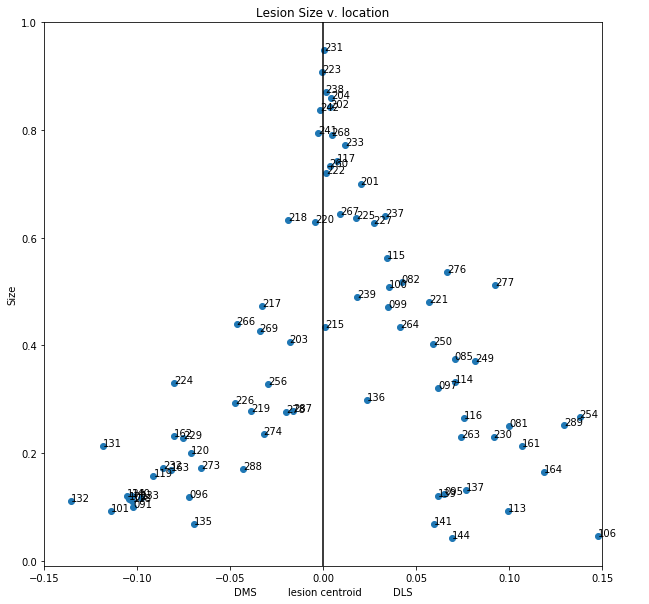

In [8]:
if "__file__" not in dir():
    plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    sc=ax.scatter(loc,size)
    ax.set_ylabel('Size')
    ax.set_xlabel('DMS          lesion centroid          DLS')
    ax.set_title('Lesion Size v. location');
    ax.axvline(0,color='k');
    ax.set_xlim([-.15,.15])

    for i, txt in enumerate(animals):
        ax.annotate(txt[-3:], (loc[i], size[i]))

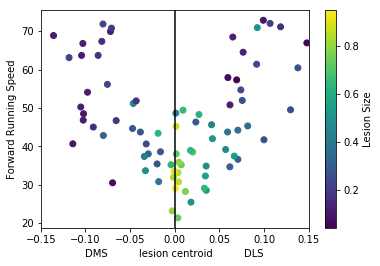

In [9]:
if "__file__" not in dir():
    cm = plt.cm.get_cmap('viridis')
    ax=plt.subplot(111)
    sc=ax.scatter(loc,behav,c=size,cmap=cm)
    ax.set_ylabel(PerfParamToPlot[0])
    ax.set_xlabel('DMS          lesion centroid          DLS')
#     ax.set_title('r='+str(np.corrcoef(behav,loc)[0,1])[:5]+', p='+str(scipy.stats.pearsonr(behav,loc)[1])[:5]);
    ax.axvline(0,color='k');
    ax.set_xlim([-.15,.15])
    cbAx=plt.colorbar(sc,ax=ax);
    cbAx.set_label("Lesion Size")

#     for i, txt in enumerate(animals):
#         ax.annotate(txt[-3:], (loc[i], behav[i]))